In [1]:
import torch
import numpy as np
import random
import zarr
from skimage.segmentation import relabel_sequential
from scipy.ndimage import distance_transform_edt, map_coordinates
from matplotlib import gridspec, ticker
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
from dlmbl_unet import UNet
import torch.nn as nn
import torchvision.transforms.v2 as transforms_v2
from torch.utils.tensorboard import SummaryWriter
import subprocess
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment

In [17]:
#Helper functions
def load_data (zarr_path):
    x_arrays = []
    y_arrays = []
    root = zarr.open (zarr_path)
    for conditions in list (root.keys()):
        images = root [conditions].keys()
        for fov in images:
            x = root[conditions][fov]["x_cropped"][:].astype ("float32")
            y = root[conditions][fov]["y_cropped"][:].astype ("int16")
            
            for i in range (x.shape[0]):
                x_slice = np.expand_dims (x[i, :, :], axis = 0)
                y_slice = np.expand_dims (y [i, :, :], axis = 0)
                # print (x_slice.shape, y_slice.shape)
                if int (y_slice.max () )> 0:
                    x_arrays.append (x_slice)
                    y_arrays.append (y_slice)
    x_array = np.concatenate (x_arrays)
    y_array = np.concatenate (y_arrays)

    return x_array, y_array


def compute_sdt(labels: np.ndarray, scale: int = 5):
    """Function to compute a signed distance transform."""
    dims = len(labels.shape)
    # Create a placeholder array of infinite distances
    distances = np.ones(labels.shape, dtype=np.float32) * np.inf
    for axis in range(dims):
        # Here we compute the boundaries by shifting the labels and comparing to the original labels
        # This can be visualized in 1D as:
        # a a a b b c c c
        #   a a a b b c c c
        #   1 1 0 1 0 1 1
        # Applying a half pixel shift makes the result more obvious:
        # a a a b b c c c
        #  1 1 0 1 0 1 1
        bounds = (
            labels[*[slice(None) if a != axis else slice(1, None) for a in range(dims)]]
            == labels[
                *[slice(None) if a != axis else slice(None, -1) for a in range(dims)]
            ]
        )
        # pad to account for the lost pixel
        bounds = np.pad(
            bounds,
            [(1, 1) if a == axis else (0, 0) for a in range(dims)],
            mode="constant",
            constant_values=1,
        )
        # compute distances on the boundary mask
        axis_distances = distance_transform_edt(bounds)

        # compute the coordinates of each original pixel relative to the boundary mask and distance transform.
        # Its just a half pixel shift in the axis we computed boundaries for.
        coordinates = np.meshgrid(
            *[
                (
                    range(axis_distances.shape[a])
                    if a != axis
                    else np.linspace(
                        0.5, axis_distances.shape[a] - 1.5, labels.shape[a]
                    )
                )
                for a in range(dims)
            ],
            indexing="ij",
        )
        coordinates = np.stack(coordinates)

        # Interpolate the distances to the original pixel coordinates
        sampled = map_coordinates(
            axis_distances,
            coordinates=coordinates,
            order=3,
        )

        # Update the distances with the minimum distance to a boundary in this axis
        distances = np.minimum(distances, sampled)

    # Normalize the distances to be between -1 and 1
    distances = np.tanh(distances / scale)

    # Invert the distances for pixels in the background
    distances[labels == 0] *= -1
    return distances

def train(
    model,
    loader,
    optimizer,
    loss_function,
    epoch,
    log_interval=100,
    log_image_interval=20,
    tb_logger=None,
    device=None,
    early_stop=False,
):
    if device is None:
        # You can pass in a device or we will default to using
        # the gpu. Feel free to try training on the cpu to see
        # what sort of performance difference there is
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")

    # set the model to train mode
    model.train()

    # move model to device
    model = model.to(device)

    # iterate over the batches of this epoch
    for batch_id, (x, y, z) in enumerate(loader):
 
        x, y = x.to(device), y.to(device)

        # zero the gradients for this iteration
        optimizer.zero_grad()

        # apply model and calculate loss
        prediction = model(x)
        assert prediction.shape == y.shape, (prediction.shape, y.shape)
        if y.dtype != prediction.dtype:
            y = y.type(prediction.dtype)
        loss = loss_function(prediction, y)

        # backpropagate the loss and adjust the parameters
        loss.backward()
        optimizer.step()

        # log to console
        if batch_id % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_id * len(x),
                    len(loader.dataset),
                    100.0 * batch_id / len(loader),
                    loss.item(),
                )
            )

        



        # log to tensorboard
        if tb_logger is not None:
            step = epoch * len(loader) + batch_id
            tb_logger.add_scalar(
                tag="train_loss", scalar_value=loss.item(), global_step=step
            )
            # check if we log images in this iteration
            if step % log_image_interval == 0:
                tb_logger.add_images(
                    tag="input", img_tensor=x.to("cpu"), global_step=step
                )
                tb_logger.add_images(
                    tag="target", img_tensor=y.to("cpu"), global_step=step
                )
                tb_logger.add_images(
                    tag="prediction",
                    img_tensor=prediction.to("cpu").detach(),
                    global_step=step,
                )

        if early_stop and batch_id > 5:
            print("Stopping test early!")
            break

def launch_tensorboard(log_dir):
    import socket

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind(("", 0))
        port = s.getsockname()[1]

    tensorboard_cmd = f"tensorboard --logdir={log_dir} --port={port}"
    process = subprocess.Popen(tensorboard_cmd, shell=True)
    print(
        f"TensorBoard started at http://localhost:{port}. \n"
        "If you are using VSCode remote session, forward the port using the PORTS tab next to TERMINAL."
    )
    return process

def plot_two(img: np.ndarray, intermediate: np.ndarray, label: str):
    """
    Helper function to plot an image and the auxiliary (intermediate)
    representation of the target.
    """
    if img.shape[0] == 2 and len(img.shape) == 3:
        img = np.array([img[0], img[1], img[0] * 0]).transpose((1, 2, 0))
    if intermediate.shape[0] == 4 and len(intermediate.shape) == 3:
        intermediate = np.array(
            [
                (intermediate[0] + intermediate[2]) / 2,
                (intermediate[1] + intermediate[3]) / 2,
                intermediate.sum(axis=0) > 0,  # any affinity is 1
            ]
        ).transpose((1, 2, 0))
    fig = plt.figure(constrained_layout=False, figsize=(10, 3))
    spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.set_xlabel("Image", fontsize=20)
    plt.imshow(img)
    ax2 = fig.add_subplot(spec[0, 1])
    ax2.set_xlabel(label, fontsize=20)
    if len(intermediate.shape) == 2:
        t = plt.imshow(intermediate, cmap="coolwarm")
        cbar = fig.colorbar(t, fraction=0.046, pad=0.04)
        tick_locator = ticker.MaxNLocator(nbins=3)
        cbar.locator = tick_locator
        cbar.update_ticks()
        _ = [ax.set_xticks([]) for ax in [ax1, ax2]]
        _ = [ax.set_yticks([]) for ax in [ax1, ax2]]
    elif len(intermediate.shape) == 3:
        plt.imshow(intermediate)

    plt.tight_layout()
    plt.show()

def plot_three(
    img: np.ndarray,
    intermediate: np.ndarray,
    pred: np.ndarray,
    label: str = "Target",
    label_cmap=None,
):
    """
    Helper function to plot an image, the auxiliary (intermediate)
    representation of the target and the model prediction.
    """
    if img.shape[0] == 2 and len(img.shape) == 3:
        img = np.array([img[0], img[1], img[0] * 0]).transpose((1, 2, 0))
    if intermediate.shape[0] == 4 and len(intermediate.shape) == 3:
        intermediate = np.array(
            [
                (intermediate[0] + intermediate[2]) / 2,
                (intermediate[1] + intermediate[3]) / 2,
                intermediate.sum(axis=0) > 0,  # any affinity is 1
            ]
        ).transpose((1, 2, 0))
    if pred.shape[0] == 4 and len(pred.shape) == 3:
        pred = np.array(
            [(pred[0] + pred[2]) / 2, (pred[1] + pred[3]) / 2, pred.mean(axis=0)]
        ).transpose((1, 2, 0))
    fig = plt.figure(constrained_layout=False, figsize=(10, 3))
    spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.set_xlabel("Image", fontsize=20)
    plt.imshow(img)
    ax2 = fig.add_subplot(spec[0, 1])
    if label_cmap is not None:
        ax2.set_xlabel("Labels", fontsize=20)
    else:
        ax2.set_xlabel(label, fontsize=20)

    if len(intermediate.shape) == 2:
        if label_cmap is None:
            plt.imshow(intermediate, cmap="coolwarm")
        else:
            plt.imshow(intermediate, cmap=label_cmap, interpolation="none")
    else:
        plt.imshow(intermediate)
    ax3 = fig.add_subplot(spec[0, 2])
    if label_cmap is not None:
        ax3.set_xlabel(label, fontsize=20)
    else:
        ax3.set_xlabel("Prediction", fontsize=20)

    if len(pred.shape) == 2:
        t = plt.imshow(pred, cmap="coolwarm")
        cbar = fig.colorbar(t, fraction=0.046, pad=0.04)
        tick_locator = ticker.MaxNLocator(nbins=3)
        cbar.locator = tick_locator
        cbar.update_ticks()
        _ = [ax.set_xticks([]) for ax in [ax1, ax2, ax3]]  # remove the xticks
        _ = [ax.set_yticks([]) for ax in [ax1, ax2, ax3]]  # remove the yticks
    else:
        plt.imshow(pred)
    plt.tight_layout()
    plt.show()

def plot_four(
    img: np.ndarray,
    intermediate: np.ndarray,
    pred: np.ndarray,
    seg: np.ndarray,
    label: str = "Target",
    cmap: str = "nipy_spectral",
):
    """
    Helper function to plot an image, the auxiliary (intermediate)
    representation of the target, the model prediction and the predicted segmentation mask.
    """

    if img.shape[0] == 2 and len(img.shape) == 3:
        img = np.array([img[0], img[1], img[0] * 0]).transpose((1, 2, 0))
    if intermediate.shape[0] == 4 and len(intermediate.shape) == 3:
        intermediate = np.array(
            [
                (intermediate[0] + intermediate[2]) / 2,
                (intermediate[1] + intermediate[3]) / 2,
                intermediate.sum(axis=0) > 0,  # any affinity is 1
            ]
        ).transpose((1, 2, 0))
    if pred.shape[0] == 4 and len(pred.shape) == 3:
        pred = np.array(
            [(pred[0] + pred[2]) / 2, (pred[1] + pred[3]) / 2, pred.mean(axis=0)]
        ).transpose((1, 2, 0))
    fig = plt.figure(constrained_layout=False, figsize=(10, 3))
    spec = gridspec.GridSpec(ncols=4, nrows=1, figure=fig)
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.imshow(img)  # show the image
    ax1.set_xlabel("Image", fontsize=20)
    ax2 = fig.add_subplot(spec[0, 1])
    if len(intermediate.shape) == 2:
        ax2.imshow(intermediate, cmap="coolwarm")
    else:
        ax2.imshow(intermediate)
    ax2.set_xlabel(label, fontsize=20)
    ax3 = fig.add_subplot(spec[0, 2])
    if len(pred.shape) == 2:
        t = ax3.imshow(pred, cmap="coolwarm")
        tick_locator = ticker.MaxNLocator(nbins=3)
        cbar = fig.colorbar(t, fraction=0.046, pad=0.04)
        cbar.locator = tick_locator
        cbar.update_ticks()
    else:
        ax3.imshow(pred)
    ax3.set_xlabel("Pred.", fontsize=20)
    ax4 = fig.add_subplot(spec[0, 3])
    ax4.imshow(seg, cmap=cmap, interpolation="none")
    ax4.set_xlabel("Seg.", fontsize=20)
    _ = [ax.set_xticks([]) for ax in [ax1, ax2, ax3, ax4]]  # remove the xticks
    _ = [ax.set_yticks([]) for ax in [ax1, ax2, ax3, ax4]]  # remove the yticks
    plt.tight_layout()
    plt.show()

def evaluate(gt_labels: np.ndarray, pred_labels: np.ndarray, th: float = 0.5):
    """Function to evaluate a segmentation."""

    pred_labels_rel, _, _ = relabel_sequential(pred_labels)
    gt_labels_rel, _, _ = relabel_sequential(gt_labels)

    overlay = np.array([pred_labels_rel.flatten(), gt_labels_rel.flatten()])

    # get overlaying cells and the size of the overlap
    overlay_labels, overlay_labels_counts = np.unique(
        overlay, return_counts=True, axis=1
    )
    overlay_labels = np.transpose(overlay_labels)

    # get gt cell ids and the size of the corresponding cell
    gt_labels_list, gt_counts = np.unique(gt_labels_rel, return_counts=True)
    gt_labels_count_dict = {}

    for l, c in zip(gt_labels_list, gt_counts):
        gt_labels_count_dict[l] = c

    # get pred cell ids
    pred_labels_list, pred_counts = np.unique(pred_labels_rel, return_counts=True)

    pred_labels_count_dict = {}
    for l, c in zip(pred_labels_list, pred_counts):
        pred_labels_count_dict[l] = c

    num_pred_labels = int(np.max(pred_labels_rel))
    num_gt_labels = int(np.max(gt_labels_rel))
    num_matches = min(num_gt_labels, num_pred_labels)

    # create iou table
    iouMat = np.zeros((num_gt_labels + 1, num_pred_labels + 1), dtype=np.float32)

    for (u, v), c in zip(overlay_labels, overlay_labels_counts):
        iou = c / (gt_labels_count_dict[v] + pred_labels_count_dict[u] - c)
        iouMat[int(v), int(u)] = iou

    # remove background
    iouMat = iouMat[1:, 1:]

    # use IoU threshold th
    if num_matches > 0 and np.max(iouMat) > th:
        costs = -(iouMat > th).astype(float) - iouMat / (2 * num_matches)
        gt_ind, pred_ind = linear_sum_assignment(costs)
        assert num_matches == len(gt_ind) == len(pred_ind)
        match_ok = iouMat[gt_ind, pred_ind] > th
        tp = np.count_nonzero(match_ok)
    else:
        tp = 0
    fp = num_pred_labels - tp
    fn = num_gt_labels - tp
    precision = tp / max(1, tp + fp)
    recall = tp / max(1, tp + fn)
    accuracy = tp / (tp + fp + fn)

    return precision, recall, accuracy

class DiceCoefficient(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    # the dice coefficient of two sets represented as vectors a, b ca be
    # computed as (2 *|a b| / (a^2 + b^2))
    def forward(self, prediction, target):
        intersection = (prediction * target).sum()
        union = (prediction * prediction).sum() + (target * target).sum()
        return 2 * intersection / union.clamp(min=self.eps)
class DiceLoss(nn.Module):
    """
    This layer will simply compute the dice coefficient and then negate
    it with an optional offset.
    We support an optional offset because it is common to have 0 as
    the optimal loss. Since the optimal dice coefficient is 1, it is
    convenient to get 1 - dice_coefficient as our loss.

    You could leave off the offset and simply have -1 as your optimal loss.
    """

    def __init__(self, offset: float = 1):
        super().__init__()
        self.offset = torch.nn.Parameter(torch.tensor(offset), requires_grad=False)
        self.dice_coefficient = DiceCoefficient()

    def forward(self, x, y):
        coefficient = self.dice_coefficient(x, y)
        return self.offset - coefficient

In [3]:
zarr_path = "/mnt/efs/aimbl_2025/student_data/S-DM/Data/zarr_storage/tangles_and_pbodies.zarr"
root = zarr.open (zarr_path)

In [ ]:
class CropDataset(Dataset):
    def __init__(self, zarr_path, transform = None, img_transform = None):
        
        
        self.zarr_path = zarr_path

        self.x, self.y = load_data(self.zarr_path)
        self.transform = transform
        self.img_transform = img_transform
        
       

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img = self.x[idx]  
        seg = self.y[idx] 

        img = torch.tensor(img).unsqueeze(0)
        seg = torch.tensor(seg).unsqueeze(0)
        sdt = torch.tensor (compute_sdt (seg))
        
        if self.transform:
            seed = torch.seed()
            torch.manual_seed(seed)
            img = self.transform (img)
            torch.manual_seed(seed)
            seg = self.transform(seg)
            torch.manual_seed(seed)
            sdt = self.transform(sdt)
            # img, sdt, seg = self.transform (img, sdt, seg)
        
        if self.img_transform:
            img = self.img_transform(img)

        

    

        return torch.tensor(img, dtype=torch.float32), torch.tensor(sdt, dtype=torch.float32), seg

In [5]:
dataset = CropDataset (zarr_path=zarr_path)

In [6]:
print (len (dataset))

3409


torch.Size([256, 256])
<built-in method max of Tensor object at 0x704020228e30>


/tmp/ipykernel_673640/3981260206.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float32), torch.tensor(sdt, dtype=torch.float32), seg


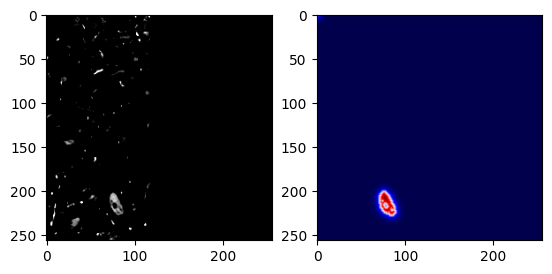

In [16]:
index = random.choice (range(0, len (dataset)))
img = dataset [index][0].squeeze(0)
print (img.shape)
sdt = dataset[index][1].squeeze (0)
print (sdt.max) # get the image and the distance transform
# We use the <code style="color: black">plot_two</code> function (imported in the first cell) to verify that our
# dataset solution is correct. The output should show 2 images: the raw image and
# the corresponding SDT.
# plot_two(img, sdt,  label="SDT")
# sdt.shape

fig, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap = "grey")
ax[1].imshow(sdt, cmap = "seismic")

In [19]:
torch.manual_seed (41)

training, validation = random_split(dataset, lengths = (0.8, 0.2))
print (f"Training dataset contains {len (training)} images")
train_dataloader = DataLoader (training, shuffle=True, batch_size=16)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = UNet(
    depth = 4,
    in_channels=1,
    out_channels=1,
    final_activation=nn.Tanh(),
    num_fmaps=16
)

learning_rate = 1e-4
loss = DiceLoss()
optimizer = torch.optim.Adam (model.parameters(), lr = learning_rate)

logger = SummaryWriter("runs/tangles_pbodies_segmentation")

Training dataset contains 2728 images


In [ ]:
launch_tensorboard("runs")

for epoch in range(1000):
    train (model= model,
           loader = train_dataloader,
            optimizer = optimizer,
            loss_function = loss, epoch = epoch, device=device, tb_logger=logger)
    if epoch % 10 ==0:
        torch.save(
            {
            "unet": model.state_dict(),
            "epoch": epoch,
                # "losses": losses,
                },
                f"/mnt/efs/aimbl_2025/student_data/S-DM/Data/checkpoints/unet_{epoch}.pth",)
print ("Training completed!")